In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import ast
import networkx as nx
import community as community_louvain
from collections import Counter, defaultdict
import netwulf as nw
import numpy as np
from Netwulf_plot_functions import netwulf_plot_communities
from community import community_louvain 
import pickle

# Focusing on artists from the US - Modularity 

In [2]:
nodes_df = pd.read_csv('nodes.csv')
edges_df = pd.read_csv('edges.csv')
nodes_df['genres'] = nodes_df['genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])
artists_us_df = pd.read_csv("most_listened_artists_in_US_dataset.csv", index_col=0)
artists_us_name_list = (artists_us_df.index).tolist()
nodes_df = nodes_df[nodes_df["name"].isin(artists_us_name_list)]
duplicate_names = nodes_df[nodes_df.duplicated(subset="name", keep=False)].sort_values(by="name")
final_cleaned_nodes_df = nodes_df.sort_values("followers", ascending=False)
final_cleaned_nodes_df = nodes_df.drop_duplicates(subset="name", keep="first")

In [3]:
def split_artists_by_genre(nodes_df, genre_names, exclusive=False):    
    nodes_df = nodes_df.copy()

    filtered_dfs = []

    for genre in genre_names:
        if exclusive:
            other_genres = [g for g in genre_names if g != genre]
            
            df = nodes_df[
                nodes_df['genres'].apply(
                    lambda genres: genre in ' '.join(genres) and all(other not in ' '.join(genres) for other in other_genres)
                )
            ].copy()
        else:
             df = nodes_df[
                nodes_df['genres'].apply(
                    lambda genres: genre in ' '.join(genres)
                )
            ].copy()
        
        filtered_dfs.append(df)

    return filtered_dfs

def get_Graph_with_names(nodes_df, edges_df, verbose=True):
    nodes_df = nodes_df.dropna(subset=['spotify_id', 'name'])
    edges_df = edges_df.dropna(subset=['id_0', 'id_1'])

    # Build ID to name map
    id_to_name = dict(zip(nodes_df['spotify_id'], nodes_df['name']))
    allowed_ids = set(id_to_name.keys())

    # Create graph with artist names as nodes
    G = nx.Graph()

    for _, row in nodes_df.iterrows():
        artist_name = row['name']
        followers = row['followers'] if not pd.isna(row['followers']) else 0
        popularity = row['popularity'] if not pd.isna(row['popularity']) else 0
        genres = row['genres']
        chart_hits = row['chart_hits'] if not pd.isna(row['chart_hits']) else []

        G.add_node(artist_name, followers=followers, popularity=popularity,
                   genres=genres, chart_hits=chart_hits)

    for _, row in edges_df.iterrows():
        id_0, id_1 = row['id_0'], row['id_1']
        if id_0 in allowed_ids and id_1 in allowed_ids:
            name_0 = id_to_name.get(id_0)
            name_1 = id_to_name.get(id_1)
            if name_0 and name_1:
                G.add_edge(name_0, name_1)

    if verbose:
        print(f"Number of nodes: {G.number_of_nodes()}")
        print(f"Number of edges: {G.number_of_edges()}")
        print(f"Network density: {nx.density(G)}")

    return G

def get_n_largest_component(G, n):
    return sorted(nx.connected_components(G), key=len, reverse=True)[n]

def apply_louvain(G, verbose=True):
    partition = community_louvain.best_partition(G)

    nx.set_node_attributes(G, partition, 'community')
    
    if verbose:
        community_sizes = Counter(partition.values())
        sorted_communities = sorted(community_sizes.items(), key=lambda x: x[1], reverse=True)
        for community_id, size in sorted_communities:
            print(f"Community {community_id}: {size} nodes")
    
    communities = defaultdict(list)
    for node, community_id in partition.items():
        communities[community_id].append(node)
    
    sorted_communities = sorted(communities.items(), key=lambda x: len(x[1]), reverse=True)
    return sorted_communities
        
def get_community_subgraph(G, community_id):
    nodes_in_community = [n for n, attr in G.nodes(data=True) if attr.get('community') == community_id]
    
    subgraph = G.subgraph(nodes_in_community).copy()
    
    return subgraph

def get_combined_louvain_splitted_graph(G):
    _G = G.copy()
    partition = community_louvain.best_partition(_G)
    nx.set_node_attributes(_G, partition, 'community')

    combined_G = nx.Graph()
    
    combined_G.add_nodes_from(_G.nodes(data=True))

    for u, v in _G.edges():
        if partition[u] == partition[v]:
            combined_G.add_edge(u, v, **_G[u][v])

    return combined_G

def print_top_collaborators(G, n):
    top_collaborators = sorted(G.degree, key=lambda x: x[1], reverse=True)[:n]

    print(f"Top {n} artists with the most collaborations:")
    for rank, (artist, degree) in enumerate(top_collaborators, start=1):
        print(f"{rank}. {artist} — {degree} collaborations")


In [4]:
df_tes = pd.read_csv("most_listened_artists_in_US_dataset.csv")
df_us = df_tes[df_tes["Country"] == "US"]
df_us = df_us.rename(columns={"Name": "name"})
us_names = df_us["name"].tolist()

In [5]:
#inal_df = final_cleaned_nodes_df[final_cleaned_nodes_df["name"].isin(us_names)]

In [6]:
final_df = final_cleaned_nodes_df
final_df

,spotify_id,name,followers,popularity,genres,chart_hits
0,48WvrUGoijadXXCsGocwM4,Byklubben,1738.0,24,"[nordic house, russelater]",['no (3)']
1,4lDiJcOJ2GLCK6p9q5BgfK,Kontra K,1999676.0,72,"[christlicher rap, german hip hop]","['at (44)', 'de (111)', 'lu (22)', 'ch (31)', ..."
15,3xs0LEzcPXtgNfMNcHzLIP,Rockwell,40344.0,58,[],"['us (1)', 'gb (1)', 'at (1)', 'be (1)', 'ca (..."
20,2NUz5P42WqkxilbI8ocN76,Vybz Kartel,1026598.0,63,"[dancehall, jamaican dancehall, reggae fusion]","['cr (3)', 'pa (1)']"
22,4Lm0pUvmisUHMdoky5ch2I,Apocalyptica,864846.0,60,"[alternative metal, bow pop, cello, finnish me...",['fi (2)']
...,...,...,...,...,...,...
155870,3a9qv6NLHnsVxJUtKOMHvD,The Glitch Mob,538974.0,61,"[edm, electro house, glitch, glitch hop, indie...",NaN
156036,7dh6G6qILmRpUtZU4ZSD4D,Trobeats,515.0,9,[],NaN
156038,7p5J8SfKU9Rulp7tcA53G8,Jose Merce,182186.0,51,"[cante flamenco, flamenco, nuevo flamenco, rumba]",NaN
156220,6kT18gnkVrCz8xJQcrib7L,Bhaskar,230894.0,60,"[brazilian bass, brazilian edm, brazilian house]",NaN


In [7]:
pop_df, rap_df = split_artists_by_genre(final_df, ["pop", "rap"])

print(len(pop_df), len(rap_df))
G_pop = get_Graph_with_names(pop_df, edges_df)
G_rap = get_Graph_with_names(rap_df, edges_df)

4398 1704
Number of nodes: 4398
Number of edges: 17648
Network density: 0.0018252140370625595
Number of nodes: 1704
Number of edges: 11704
Network density: 0.008066405873093326


In [60]:
nx.get_node_attributes(G_pop, "popularity")

{'Apocalyptica': 60,
 'Dua Lipa': 88,
 'Stefanie Sun': 57,
 'Twins': 45,
 'Aspova': 57,
 'Ray Dalton': 71,
 'SAMSONS': 57,
 'Darío Gómez': 58,
 'JEON SOYEON': 56,
 'Cakra Khan': 52,
 'Antti Ketonen': 32,
 'Alex Ubago': 64,
 'Innertier': 38,
 'OG Ulla-Maija': 39,
 'Powderfinger': 57,
 'Phoebe Ryan': 55,
 'Sonoko Inoue': 55,
 'Mente Fuerte': 53,
 'Martin Stenmarck': 37,
 'MKTO': 66,
 'Lauana Prado': 69,
 'Ruben Annink': 43,
 'Kuningasidea': 33,
 'Herbert Grönemeyer': 57,
 'Joe Stone': 55,
 'Devano': 45,
 'Andre Hazes': 60,
 'Kygo': 80,
 'El Villano': 45,
 'Orgânico': 54,
 'AURORA': 73,
 'Kjartan Lauritzen': 42,
 'Diego Boneta': 51,
 'Die Ärzte': 65,
 'HIRAIDAI': 66,
 'Rino Gaetano': 55,
 'R-chord': 45,
 'Indila': 68,
 'John Denver': 67,
 'Imran Khan': 63,
 'Guizmo': 52,
 'Röyksopp': 62,
 'Epik High': 56,
 'Sezen Aksu': 68,
 'Myra Granberg': 54,
 'URBOYTJ': 52,
 'Matoma': 66,
 '13 Block': 52,
 'Alligatoah': 65,
 'Murilo Huff': 72,
 'Miguel': 77,
 'Ingrid Michaelson': 59,
 'Tinashe': 69,
 

In [8]:
communities = apply_louvain(G_rap)
largest_community_id = communities[0][0]

G_largest_rap_community = get_community_subgraph(G_rap, largest_community_id)
G_largest_rap_community_splitted = get_combined_louvain_splitted_graph(G_largest_rap_community)

communities = apply_louvain(G_pop)
largest_community_id = communities[0][0]
G_largest_pop_community = get_community_subgraph(G_pop, largest_community_id)


Community 2: 455 nodes
Community 5: 259 nodes
Community 23: 142 nodes
Community 14: 123 nodes
Community 11: 122 nodes
Community 9: 98 nodes
Community 27: 91 nodes
Community 16: 64 nodes
Community 7: 56 nodes
Community 68: 27 nodes
Community 21: 26 nodes
Community 22: 20 nodes
Community 4: 18 nodes
Community 57: 17 nodes
Community 12: 5 nodes
Community 55: 5 nodes
Community 84: 4 nodes
Community 120: 4 nodes
Community 31: 3 nodes
Community 43: 3 nodes
Community 114: 3 nodes
Community 150: 3 nodes
Community 48: 2 nodes
Community 91: 2 nodes
Community 92: 2 nodes
Community 113: 2 nodes
Community 124: 2 nodes
Community 3: 1 nodes
Community 6: 1 nodes
Community 10: 1 nodes
Community 13: 1 nodes
Community 15: 1 nodes
Community 17: 1 nodes
Community 18: 1 nodes
Community 20: 1 nodes
Community 24: 1 nodes
Community 25: 1 nodes
Community 26: 1 nodes
Community 28: 1 nodes
Community 29: 1 nodes
Community 30: 1 nodes
Community 32: 1 nodes
Community 33: 1 nodes
Community 34: 1 nodes
Community 36: 1

## METRICS

In [116]:
import networkx as nx
import numpy as np
from multiprocessing import get_context
import random as rnd
import scipy.stats as stats

def double_egde_swap(original_G): 
    G2 = original_G.copy()
    edges = set(G2.edges())

    for i in range(len(edges)*10): 
        swap_successful = False
        while not swap_successful: 
            e1,e2 = rnd.sample(list(edges), 2)
            if e1[0] != e2[1] and e1[1] != e2[0] and e1[0] != e2[0] and e1[1] != e2[1]: 
                old_e1 = e1
                if rnd.random() >0.5: 
                    e1 = (e1[1], e1[0])
                
                e11 = (e1[0], e2[1])
                e22 = (e2[0], e1[1])
                if (e11 not in G2.edges()) and (e22 not in G2.edges()) and ( e11[0] != e11[1] or e22[0] != e22[1]): 
                    #update egdes set
                    edges.remove(old_e1)
                    edges.remove(e2)
                    edges.add(e11)
                    edges.add(e22)

                    #Remove old egdes and Add new egdes
                    G2.remove_edges_from([old_e1,e2])
                    G2.add_edges_from([e11,e22])
        
                    swap_successful = True

    return G2

def run_parallel(G):
    p = get_context("fork").Pool(8)
    results = p.map(double_egde_swap, [G for _ in range(8)])
    p.close()
    return results

def degree_assortativity(G):
    edges = list(G.edges())
    deg = dict(G.degree())

    deg_u = []
    deg_v = []

    for u, v in edges:
        deg_u.append(deg[u])
        deg_v.append(deg[v])

    # Now compute Pearson correlation
    return np.corrcoef(deg_u, deg_v)[0, 1]

def modularity(G, partition_dict):
    communities = {}
    for node, community in partition_dict.items():
        communities.setdefault(community, set()).add(node)

    L = G.number_of_edges()
    M = 0

    for community_nodes in communities.values():
        Lc = sum(1 for u, v in G.edges() if u in community_nodes and v in community_nodes)
        kc = sum(dict(G.degree(n for n in community_nodes)).values())
        M += (Lc / L) - (kc / (2 * L)) ** 2

    return M

def plot_significance(rnd_values:list, test_value:int, metric_type:str, genre:str, xrange:tuple, color:str):
    num_bins = 1000

    plt.figure(figsize=(25,9))
    plt.hist(rnd_values, bins=num_bins, range=xrange,edgecolor='black', alpha=0.7, label=f"{metric_type} histogram of 1000 random graphs")
    plt.xlabel('Value',  fontname="monospace", fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    #plt.axvline(np.mean(mods), color="black", linestyle='--', label=r'$\mu$ modularity of 1000 random graphs', linewidth=2.5)
    plt.axvline(test_value, color=color, linestyle="--", label=f"{metric_type} of {genre}", linewidth=2.5)
    plt.ylabel('Frequency',  fontname="monospace", fontsize=18)
    plt.title(f"{metric_type} of {genre}", fontsize=24, fontname="monospace", fontweight='bold') #plt.title("Accuracy of Entropy and Random", fontsize=16, fontname="monospace", fontweight='bold')
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.legend(fontsize=20)
    plt.show()

def stats_checker(G, genre:str): 
    num_nodes = G.number_of_nodes()
    avg_degree = sum(dict(G.degree()).values()) / G.number_of_nodes()
    print(f"{genre}-graph number of nodes: {num_nodes}   and average node degree of {avg_degree}")

def assortative(G, attribute): 
    attr_values = {G.nodes[n][attribute] for n in G.nodes}
    attr_indices = {attr: i for i, attr in enumerate(attr_values)}
    n_att = len(attr_values)

    #initialize e matrix: 
    e = np.zeros([n_att, n_att])

    for u, v in G.edges:
        attr_u = G.nodes[u][attribute]
        attr_v = G.nodes[v][attribute]
        i, j = attr_indices[attr_u], attr_indices[attr_v]
        e[i, j] += 1

    #normalize e 
    e = e/G.number_of_edges()

    #Calculating assorsativity coefficient
    a = e.sum(axis=0)
    b = e.sum(axis=1)
    eii = np.trace(e)
    sum_ab = np.sum(a*b)
    r = (eii - sum_ab)/(1-sum_ab) 
    return r
#plot_significance([1,2,3], 0.333, "Modularity histogram of 1000 random graphs")

Having dived into the two american communities results in two american subgraphs with the following properties

In [112]:
stats_checker(G_largest_rap_community, "RAP")
stats_checker(G_largest_pop_community, "POP")

RAP-graph number of nodes: 455   and average node degree of 20.41318681318681
POP-graph number of nodes: 807   and average node degree of 9.967781908302355


This plays an important role in our network analysis, since we cannot directly compare metrics such as modularity which is very much dependent on the internal network structure. 

Instead we focus our analysis on comparing with random null models made with our double-edge-swap algorithm from week 6. For our network analysis we will examine modularity, degree assortativity and how degre and the attribute "popularity" correlate

We create a 1000 random graphs for both networks:

In [113]:
pop_rnd_networks = []
rap_rnd_networks = []

if False: 
    for i in range(126): 
        pop_rnd_networks += run_parallel(G_largest_pop_community)
        print(i)
    for i in range(126): 
        rap_rnd_networks += run_parallel(G_largest_rap_community)
        print(i)
else: 
    with open("1000random_networks_POP.pkl", "rb") as f: 
        pop_rnd_networks = pickle.load(f)
    with open("1000random_networks_RAP.pkl", "rb") as f: 
        rap_rnd_networks = pickle.load(f)

### Modularity

We compute the modularity based on communities created by the louvain algorithm. 

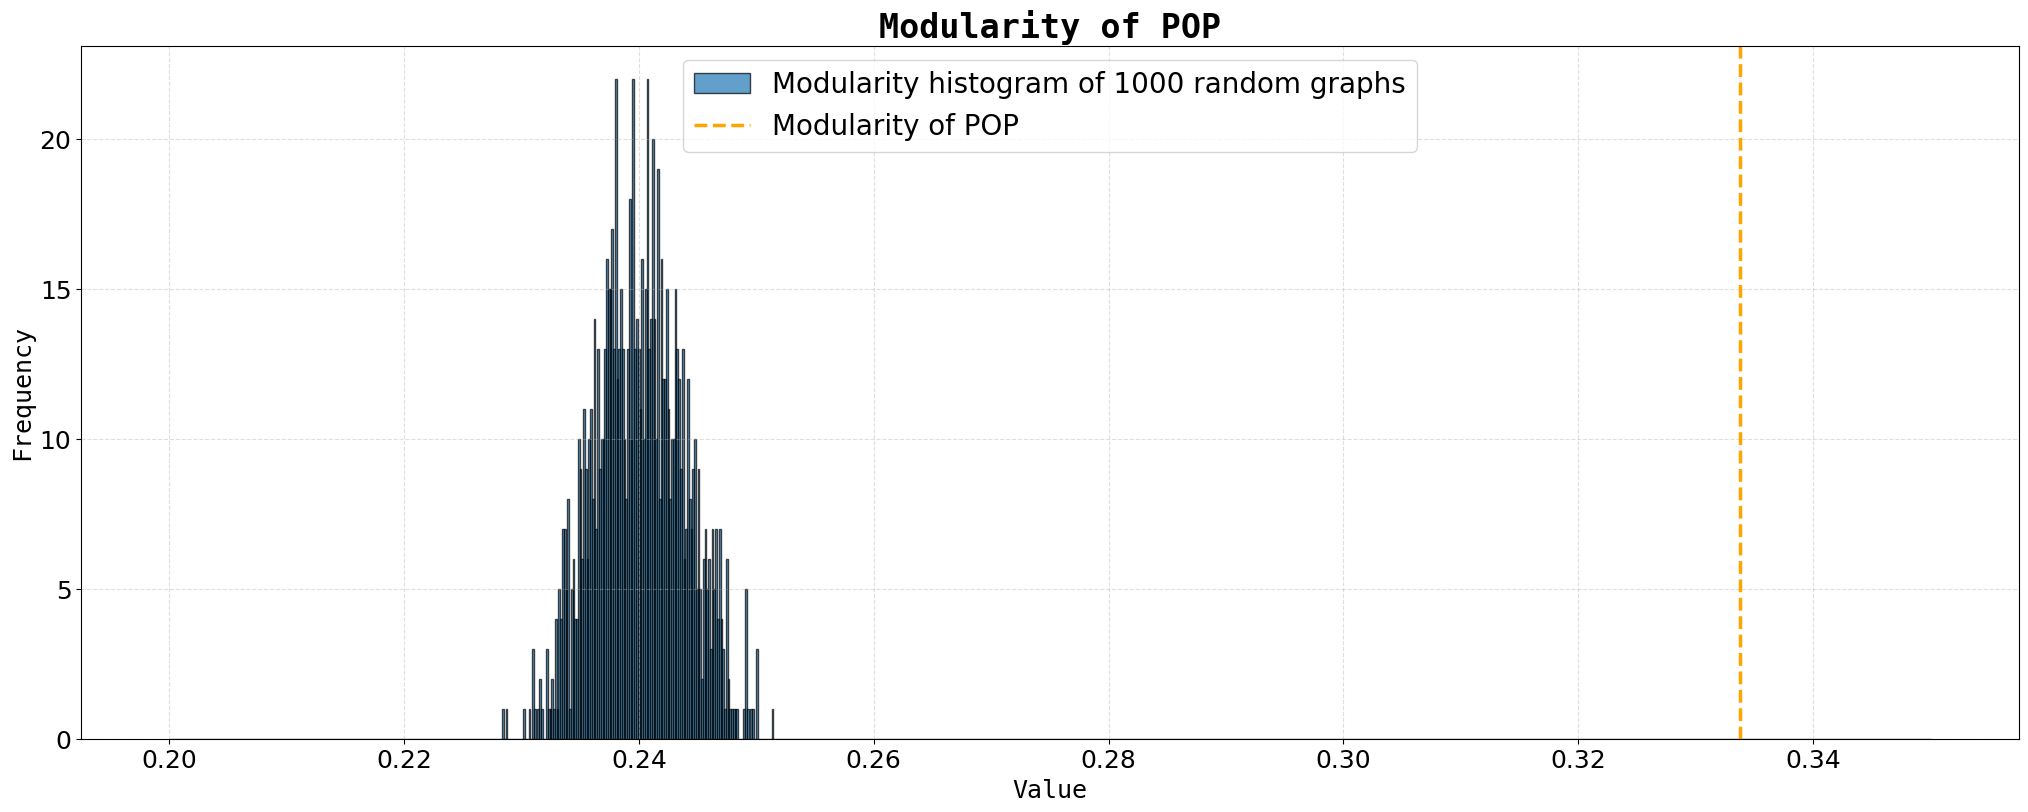

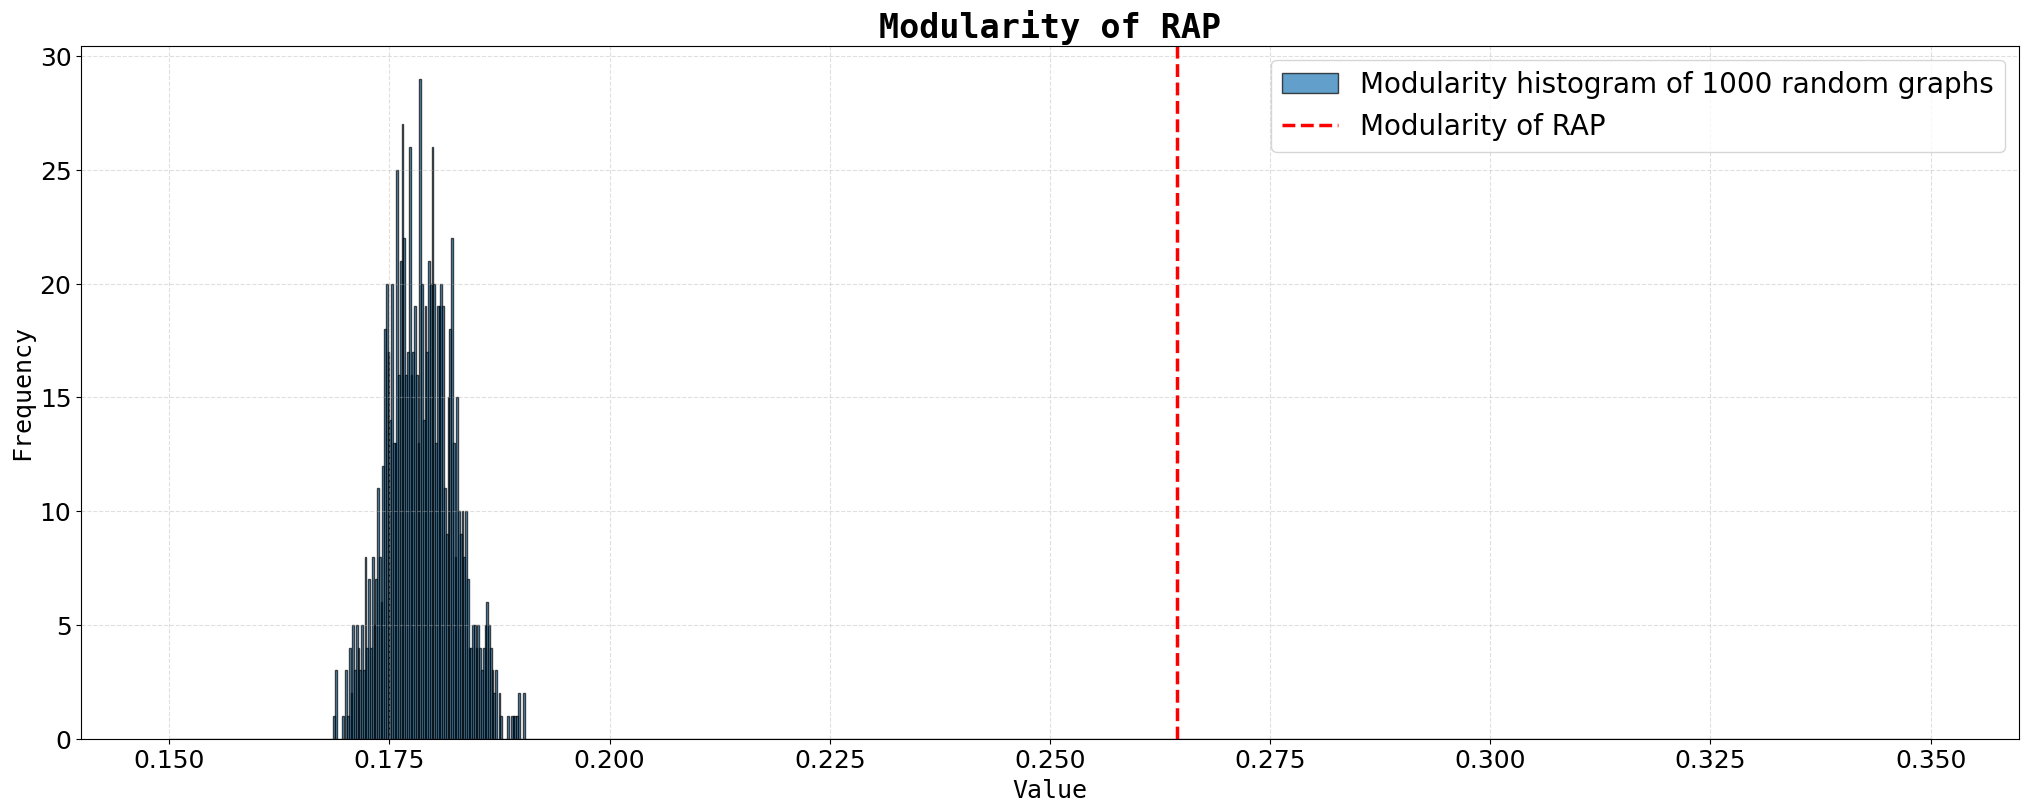

In [118]:
## POP 
p_community = community_louvain.best_partition(G_largest_pop_community)
p_mod = modularity(G_largest_pop_community, p_community)

p_mods = []
for g in pop_rnd_networks: 
    community = community_louvain.best_partition(g)
    p_mods.append(modularity(g, community))

plot_significance(p_mods, p_mod, metric_type="Modularity", genre="POP", xrange=(0.2,0.35), color="orange")

## RAP 
r_community = community_louvain.best_partition(G_largest_rap_community)
r_mod = modularity(G_largest_rap_community, r_community)

r_mods = []
for g in rap_rnd_networks: 
    community = community_louvain.best_partition(g)
    r_mods.append(modularity(g, community))

plot_significance(r_mods, r_mod, metric_type="Modularity", genre="RAP", xrange=(0.15,0.35), color="red")

Both POP and RAP collaboration networks exhibit clear community structures as indicated by the modularity scores significantly higher than those of their repsective null models. While POP shows slightly higher modularity than RAP, direct comparison is difficult due to the differences in number of nodes and average node degree. 

What can be confidently concluded is that both genres are characterized by meaningful community structures, suggesting that artists tend to cluster into collaboration groups, whether based on label, style or "crew"

### Assortatiity

In [ ]:
p_assort = degree_assortativity(G_largest_pop_community)
p_assorts = [degree_assortativity(g) for g in pop_rnd_networks]

r_assort = degree_assortativity(G_largest_rap_community)
r_assorts = [degree_assortativity(g) for g in rap_rnd_networks]

plot_significance(p_mods, p_mod, metric_type="Assortativity", genre="POP", xrange=(0.2,0.35), color="orange")
plot_significance(r_mods, r_mod, metric_type="Assortativity", genre="RAP", xrange=(0.15,0.35), color="red")

### NOTES

In [103]:
p_assort = degree_assortativity(G_largest_pop_community)#assortative(G_largest_pop_community, "popularity")
p_assorts = [degree_assortativity(g) for g in pop_rnd_networks]

G = G_largest_pop_community

degrees = [G.degree[n] for n in G.nodes]
popularities = [G.nodes[n]['popularity'] for n in G.nodes]
corr, _ = stats.pearsonr(degrees, popularities)

Modularity of POP: 0.32983032654067473, and the average of null models: 0.24037142027584427
Degree assortativity of POP: -0.01639989511595668, and the average of null models: -0.11641794898450765
Correlation between popularity and out-degree 0.38835206407659933


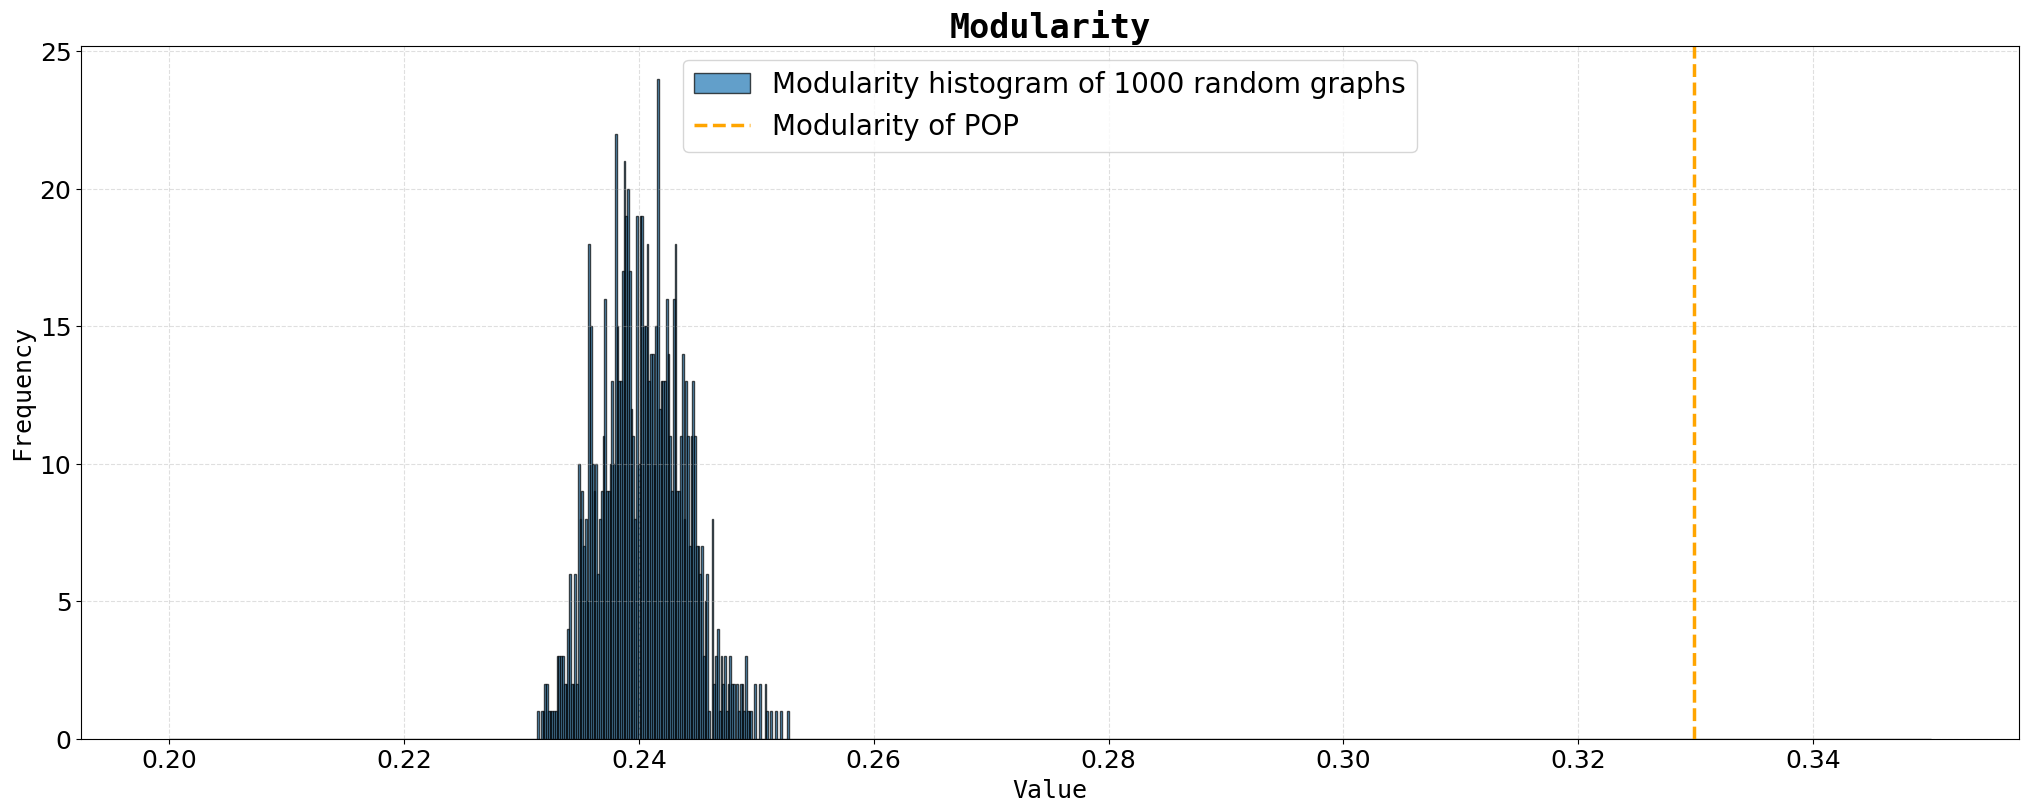

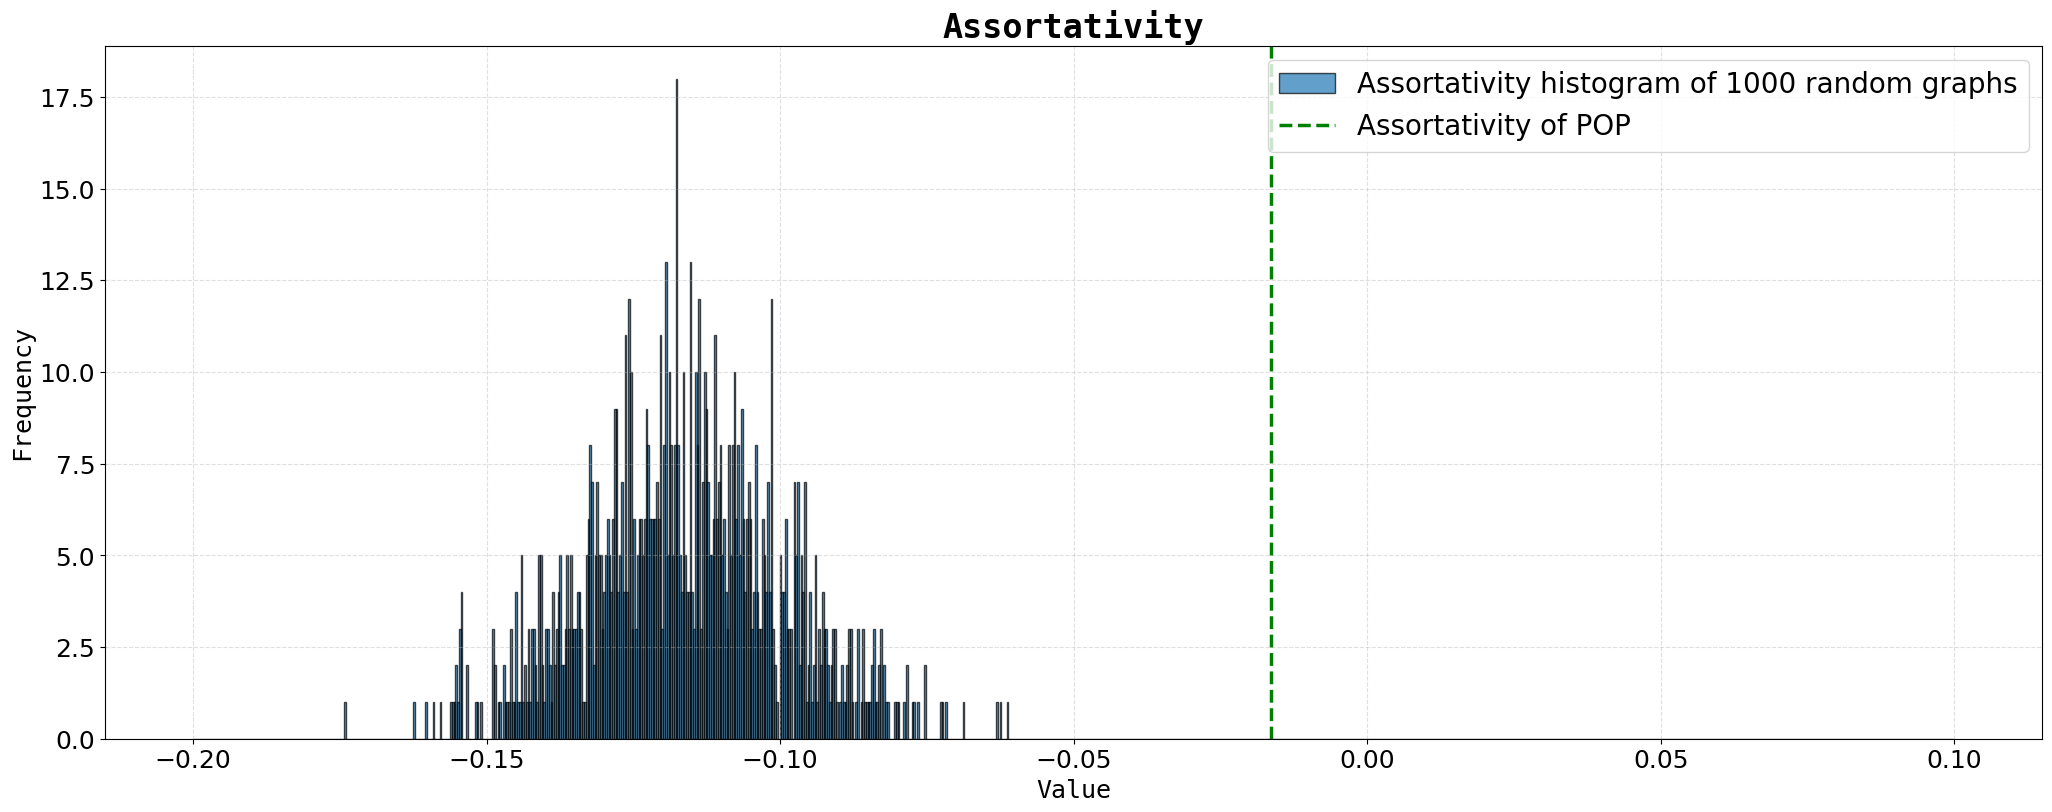

In [109]:
print(f"Modularity of POP: {p_mod}, and the average of null models: {np.mean(p_mods)}")
print(f"Degree assortativity of POP: {p_assort}, and the average of null models: {np.mean(p_assorts)}")
print("Correlation between popularity and out-degree", corr)
plot_significance(p_mods, p_mod, metric_type="Modularity", genre="POP", xrange=(0.2,0.35), color="orange")
plot_significance(p_assorts, p_assort, metric_type="Assortativity", genre="POP", xrange=(-0.2,0.1), color="green")

In [91]:
## RAP 
#MODULARITY
r_community = community_louvain.best_partition(G_largest_rap_community)
r_mod = modularity(G_largest_rap_community, r_community)

r_mods = []
for g in rap_rnd_networks: 
    community = community_louvain.best_partition(g)
    r_mods.append(modularity(g, community))

In [101]:
r_assort = degree_assortativity(G_largest_rap_community)#assortative(G_largest_rap_community, "popularity")
r_assorts = [degree_assortativity(g) for g in rap_rnd_networks]

G = G_largest_rap_community

degrees = [G.degree[n] for n in G.nodes]
popularities = [G.nodes[n]['popularity'] for n in G.nodes]
corr, _ = stats.pearsonr(degrees, popularities)

Modularity of RAP: 0.2663764233957331, and the average of null models: 0.17836541210834916
Degree assortativity of RAP: -0.013193030005696387, and the average of null models: -0.11910496055841951
Correlation between popularity and out-degree 0.38835206407659933


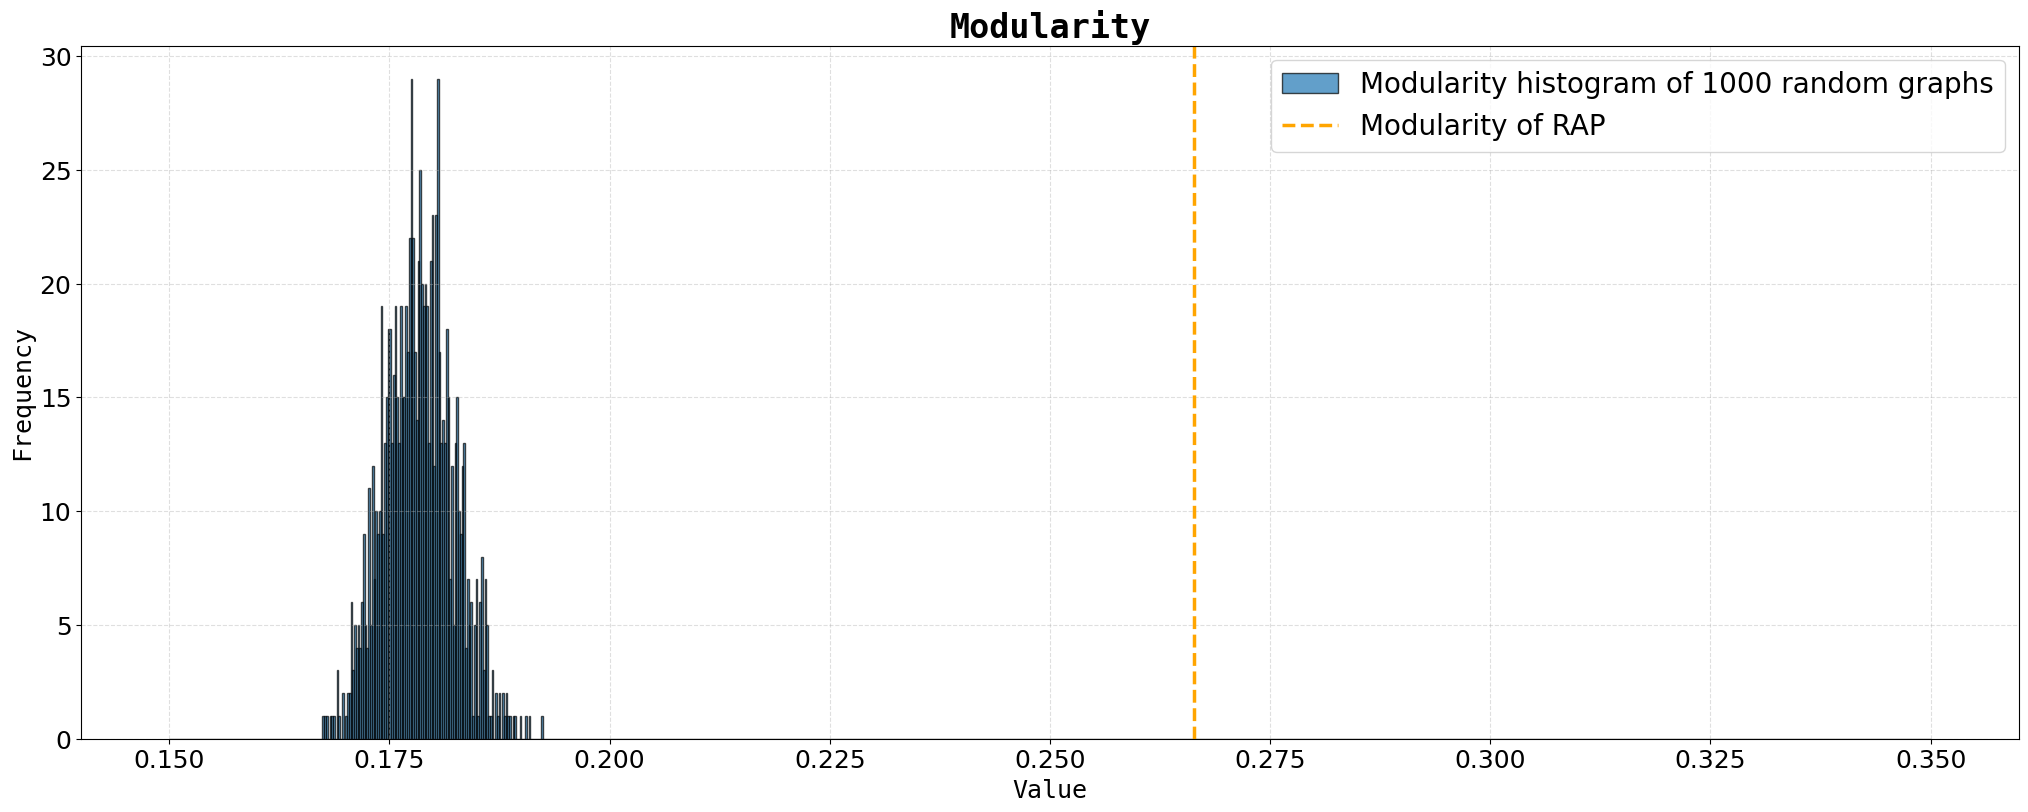

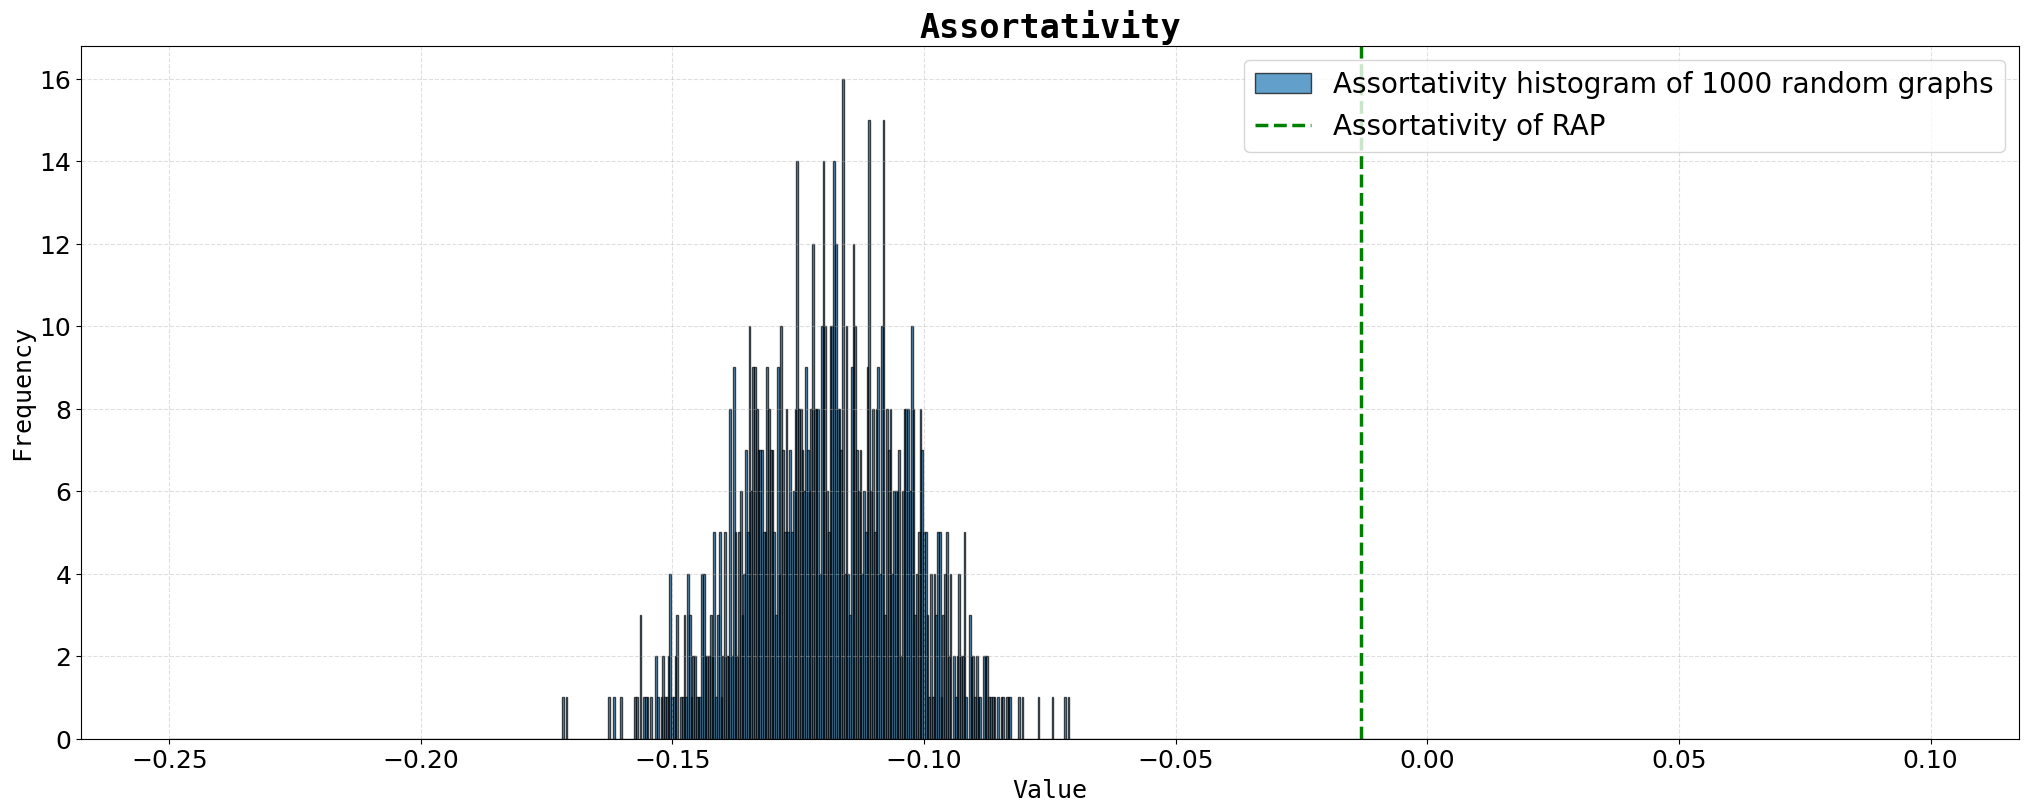

In [110]:
print(f"Modularity of RAP: {r_mod}, and the average of null models: {np.mean(r_mods)}")
print(f"Degree assortativity of RAP: {r_assort}, and the average of null models: {np.mean(r_assorts)}")
print("Correlation between popularity and out-degree", corr)
plot_significance(r_mods, r_mod, metric_type="Modularity", genre="RAP", xrange=(0.15,0.35), color="orange")
plot_significance(r_assorts, r_assort, metric_type="Assortativity", genre="RAP", xrange=(-0.25,0.1), color="green")

### TRASH

# FOR FIXING POP AND RAP LYRICS

In [201]:
with open("Missing1.pkl", "rb") as f: 
    df1 = pickle.load(f)
new = [res for res in df1[0].tolist() if res != None]
df2 = pd.DataFrame(new)

In [202]:
df2

,name,lyrics
0,Takeoff,[88 ContributorsCasper LyricsOriginally teased...
1,Black Eyed Peas,[192 ContributorsTranslationsPortuguêsFrançais...
2,Migos,[636 ContributorsTranslationsPortuguêsРусскийI...
3,Pusha T,[498 ContributorsTranslationsPortuguêsРусскийE...
4,Janusz Walczuk,[31 ContributorsJanusz Walczuk Lyrics[Zwrotka ...
...,...,...
127,N'Samble,[]
128,Lo Blanquito,[4 ContributorsTelacuti Lyrics“Telacuti” habla...
129,Steve Lacy,[108 ContributorsTranslationsРусскийDark Red L...
130,Fazura,[1 ContributorCinderella Lyrics[Verse 1: Fatta...


In [179]:
with open("Missing2.pkl", "rb") as f: 
    df = pickle.load(f)
df[df["name"] == "Omar Rudberg"]["lyrics"].item()

['7 ContributorsTranslationsEnglishPortuguêsSimon’s Song (From the Netflix Series Young Royals) LyricsForna dagar, flydda år\nDe säger tid läker alla sår\nDet gjorde ont, jag tappa bort mig själv\nJag var lost, innan jag hittade hem\nDet vi hade och de vi var\nKan aldrig glömma allt som var bra\nOm ni kräver mig på svar\nLever alla minnen kvar\n\nVi har prövats, vi fick slåss\nMen det vi var kan ingen ta från oss\nGår skilda vägar när det är slut\nNåt som jag kommer minnas livet ut\n\nDet vi hade och de vi var\nKan aldrig glömma allt som var bra\nOm frågan har ett svar\nLever Hillerska alltid kvar\n\nOm du såg mig här i dag\nSåg hur längtan gör mig svag\nOch de minnen som finns kvar inom mig\nJa, om jag såg dig här i dag\nJag skulle fråga hur det var\nOch om minnena finns kvar inom dig\n\n\nVi har prövats, vi fick slåss\nMen det vi var kan ingen ta från oss\nGår skilda vägar när det är slut\nNåt jag kommer minnas livet ut',
 "13 ContributorsIt Takes a Fool to Remain Sane Lyrics[Verse 1

In [223]:
with open("rap_df.pkl", "rb") as f: 
    rap_df = pickle.load(f)

In [233]:
rap_df[rap_df["lyrics"].isna()]

,spotify_id,name,followers,popularity,genres,chart_hits,lyrics
37,1xr2G8Hlx4QWmT9HaUbmoO,Young Stoner Life,90775.0,65,"[hip hop, rap, southern hip hop, trap]","['us (10)', 'gb (3)', 'au (1)', 'at (2)', 'be ...",NaN
97,1yxSLGMDHlW21z4YXirZDS,Black Eyed Peas,6881366.0,80,"[dance pop, pop, pop rap]","['us (3)', 'gb (2)', 'ar (3)', 'au (3)', 'at (...",NaN
98,4VMYDCV2IEDYJArk749S6m,Daddy Yankee,29446452.0,87,"[latin hip hop, reggaeton, trap latino]","['us (3)', 'gb (1)', 'ar (32)', 'au (1)', 'at ...",NaN
129,2KpK4apOMD6evPHoPggSVF,LEX,92800.0,55,"[j-rap, japanese trap]",['jp (1)'],NaN
152,0ONHkAv9pCAFxb0zJwDNTy,Pusha T,2551259.0,73,"[hip hop, pop rap, rap, southern hip hop, trap...","['us (14)', 'gb (3)', 'au (1)', 'bg (5)', 'ca ...",NaN
153,699OTQXzgjhIYAHMy9RyPD,Playboi Carti,6914690.0,82,"[atl hip hop, plugg, pluggnb, rap]","['us (26)', 'gb (2)', 'au (3)', 'at (1)', 'be ...",NaN
158,0YinUQ50QDB7ZxSCLyQ40k,Mustard,992953.0,72,"[cali rap, hip hop, pop, pop rap, rap, souther...","['us (8)', 'gb (3)', 'au (4)', 'at (1)', 'be (...",NaN
161,2Mu5NfyYm8n5iTomuKAEHl,Ms. Lauryn Hill,2246672.0,71,"[alternative r&b, conscious hip hop, neo soul,...","['gb (1)', 'ie (1)']",NaN
323,0iEtIxbK0KxaSlF7G42ZOp,Metro Boomin,3030563.0,79,"[hip hop, rap, southern hip hop, trap]","['us (14)', 'gb (6)', 'au (2)', 'at (1)', 'be ...",NaN
396,7dGJo4pcD2V6oG8kP0tJRR,Eminem,59184634.0,90,"[detroit hip hop, hip hop, rap]","['us (78)', 'gb (72)', 'ar (7)', 'au (64)', 'a...",NaN


In [232]:
for idx, name in rap_df[rap_df["name"].isin(df["name"].tolist())]["name"].items(): 
    try: 
        rap_df.at[idx, 'lyrics'] = df[df["name"] == name]["lyrics"].item()
    except:
        print(idx, name)

In [218]:
df2[df2["name"] == "Cardi B"]["lyrics"].item()

['645 ContributorsTranslationsTürkçeEspañolСрпскиРусскийRomânăPortuguêsDeutschFrançaisNederlandsالعربية中文ΕλληνικάPolskiWAP Lyrics“WAP” (Wet-Ass Pussy) is Cardi B’s fourth number 1 hit on Billboard, her first release of 2020, and her first single since 2019’s “Press.” It is expected to appear on her upcoming second studio album and… Read More\xa0[Intro: Cardi B, Al "T" McLaran & Megan Thee Stallion]\nWhores in this house\nThere\'s some whores in this house\nThere\'s some whores in this house\nThere\'s some\u2005whores\u2005in this house\u2005(Hol\' up)\nI said certified freak, seven\u2005days a week\nWet-ass pussy, make that pullout game weak, woo (Ah)\n\n[Chorus: Cardi B]\nYeah, yeah, yeah, yeah\nYeah, you fuckin\' with some wet-ass pussy\nBring a bucket and a mop for this wet-ass pussy\nGive me everything you got for this wet-ass pussy\n\n[Verse 1: Cardi B & Megan Thee Stallion]\nBeat it up, nigga, catch a charge\nExtra large and extra hard\nPut this pussy right in your face\nSwipe yo

In [221]:
pop_df[pop_df["lyrics"].isna()]

,spotify_id,name,followers,popularity,genres,chart_hits,lyrics
62,0tzSBCPJZmHTdOA3ZV2mN3,CL,1064466.0,60,[k-pop],"['bg (1)', 'hk (1)', 'id (2)', 'my (4)', 'ph (...",NaN
64,1n9MS5jDsiVS3x3ArntcnW,Lin Hsin Yi,48805.0,35,"[mandopop, taiwan pop]",['tw (4)'],NaN
94,2h93pZq0e7k5yf4dywlkpM,Frank Ocean,9951370.0,83,"[hip hop, lgbtq+ hip hop, neo soul, pop]","['us (17)', 'gb (10)', 'au (15)', 'at (1)', 'b...",NaN
117,19ra5tSw0tWufvUp8GotLo,George Michael,3898805.0,71,[dance pop],"['gb (3)', 'ar (1)', 'au (2)', 'be (3)', 'bg (...",NaN
182,3w8fdvgPp2aKgy125EBgVg,玖壹壹,175195.0,48,"[mandopop, taiwan hip hop, taiwan pop]",['tw (12)'],NaN
...,...,...,...,...,...,...,...
4257,04XdCDDrPnnqidaVBTOQjt,Hernan y La Champion's Liga,96920.0,54,"[cumbia pop, cumbia villera]",NaN,NaN
4259,2OaHYHb2XcFPvqL3VsyPzU,Rico Nasty,949031.0,67,"[alternative r&b, dance pop, dmv rap, escape r...",NaN,NaN
4272,1wiBLzTI7z9RUwEpNPdFT6,Mase,679487.0,65,"[gangster rap, hardcore hip hop, harlem hip ho...",NaN,NaN
4331,1oKdM70mJD8VvDOTKeS8t1,Emily Warren,57320.0,56,[nyc pop],NaN,NaN


In [234]:
with open("rap_dfV2.pkl", "wb") as f: 
    pickle.dump(rap_df, f)